In [1]:
using Plots
using LinearAlgebra
using Revise
using Optim
using Zygote
using LaTeXStrings
using MultiFloats
using SparseIR
using Nevanlinna

┌ Info: Precompiling Nevanlinna [0b21cfa8-e591-48a4-a07b-a9d20be7c264]
└ @ Base loading.jl:1662


In [2]:
T = BigFloat

BigFloat

In [3]:
beta::Float64 = 100
wmax::Float64 = 100
basis = FiniteTempBasisSet(Float64(beta), Float64(wmax), 1e-15) 

FiniteTempBasisSet with β = 100.0, ωmax = 100.0

In [4]:
include("../flex_src/IRFLEX.jl")

Main.IRFLEX

In [5]:
nsize::Int64 = 128
t_pra::Float64 = 0.0
filling::Float64 = 1.0
scale::Float64 = 0.1
#U::Float64 = 0.4 ##w=4
#U::Float64 = 0.2 ##w=2
U::Float64 = 0.1 ##w=1
function single_Hami(x::Float64, y::Float64, t::Float64, t_pra::Float64)::Float64
    e::Float64 = -2.0*t*(cos(x)+cos(y)) + 4.0*t_pra*cos(x)*cos(y)                   
end
hami::Function = (x,y) -> single_Hami(x,y,0.125,t_pra)
#U::Float64 = 0.5
#hami::Function = (x,y) -> IRFLEX.single_Hami(x,y,t_pra)
lat = IRFLEX.SingleLatticeModel(nsize, filling, U, SparseIR.β(basis), hami)
;

In [6]:
ratio_U = 0.0
precision = 1e-4
loose_precision = 1e+3*precision
gkf0 = IRFLEX.make_free_giw(lat, basis)
;

In [7]:
# Compute chi0
chi0kf = IRFLEX.calc_chi0(gkf0, lat, basis)
;

In [8]:
# Compute chi
chiskf = chi0kf ./ (1.0 .- lat.U*chi0kf)
;

In [9]:
hnw = (length(basis.smpl_wn_b.sampling_points)-1)÷2

52

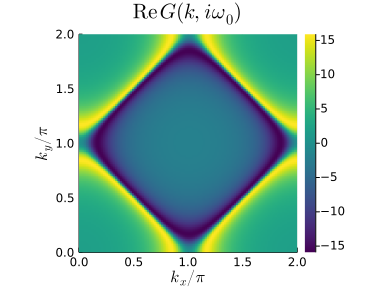

In [10]:
myx = (2 .* collect(1:nsize) .- 1) ./ nsize
myy = (2 .* collect(1:nsize) .- 1) ./ nsize
heatmap(myx, myy, real.(gkf0[hnw+1,:,:]), 
    title=latexstring("\\mathrm{Re}\\,G(k,i\\omega_0)"), xlabel=latexstring("k_x/\\pi"), ylabel=latexstring("k_y/\\pi"), 
    c=:viridis, 
    xlim = (0,2), ylim = (0,2), aspect_ratio=1.0, size=(370,300))

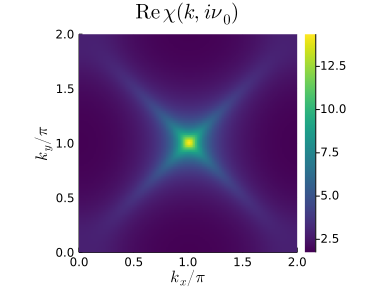

In [11]:
# plot 2D k-dependence of lowest Matsubara frequency of e.g. chi0
myx = (2 .* collect(1:nsize) .- 1) ./ nsize
myy = (2 .* collect(1:nsize) .- 1) ./ nsize
heatmap(myx, myy, real.(chiskf[hnw+1,:,:]),
    title=latexstring("\\mathrm{Re}\\,\\chi(k,i\\nu_0)"), xlabel=latexstring("k_x/\\pi"), ylabel=latexstring("k_y/\\pi"),
    c=:viridis,
    xlim = (0,2), ylim = (0,2), aspect_ratio=1.0, size=(370,300))

In [12]:
#smpl_wn_b = SparseIR.default_matsubara_sampling_points(basis.basis_b)
#smpl_wn_b = smpl_wn_b[smpl_wn_b .!= BosonicFreq(0)]
#smpl_wn_b_wo_zero = MatsubaraSampling(basis.basis_b, smpl_wn_b)
;

In [13]:
chisf = chi0kf[:,nsize÷2+1, nsize÷2+1]
#deleteat!(chisf, hnw+1)
#chisl = fit(smpl_wn_b_wo_zero, chisf, dim=1)
#chisf[37] = 0
chisl = fit(basis.smpl_wn_b, chisf, dim=1)
;

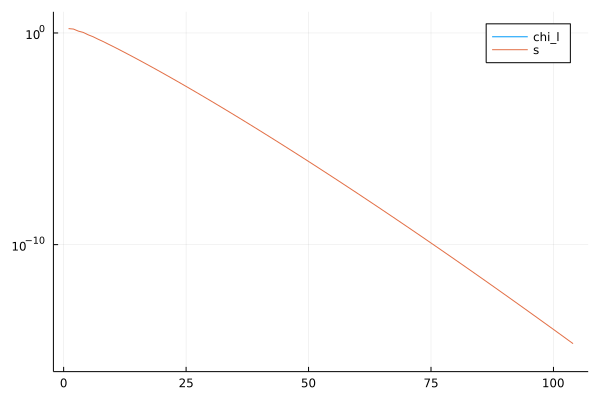

In [14]:
plot(yaxis=:log,ylims=(1e-16,10))
#plot()
plot!(real.(chisl),label="chi_l")
plot!(real.(basis.basis_b.s),label="s")

In [15]:
#smpl_wn_b_dense = MatsubaraSampling(basis.basis_b, SparseIR.BosonicFreq.(collect(-2332:2:2332)))
#chisl_d = fit(basis.smpl_wn_b, chisf)
#chisf_d = evaluate(smpl_wn_b_dense, chisl_d)
#deleteat!(chisf_d, 1167)
#chisf_d[1167]=0.0
#chisl_d = fit(smpl_wn_b_dense, chisf_d)
;

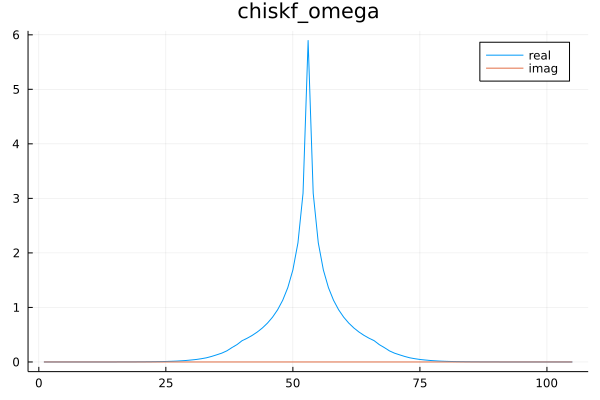

In [16]:
plot(title="chiskf_omega")
plot!(real.(chisf), label="real")
plot!(imag.(chisf), label="imag")

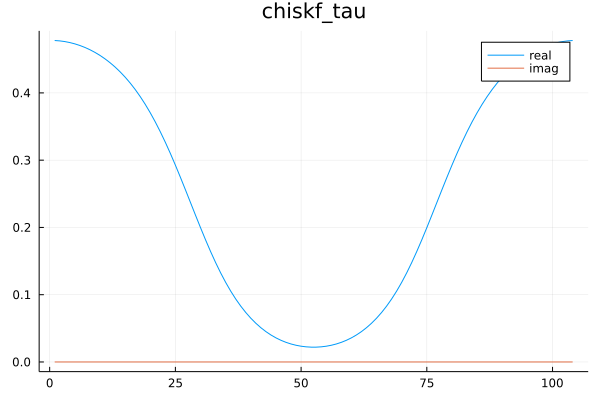

In [17]:
chist = evaluate(basis.smpl_tau_b, chisl)
plot(title="chiskf_tau")
plot!(real.(chist[:]), label="real")
plot!(imag.(chist[:]), label="imag")

In [18]:
chisw = evaluate(basis.smpl_wn_f, chisl)
;

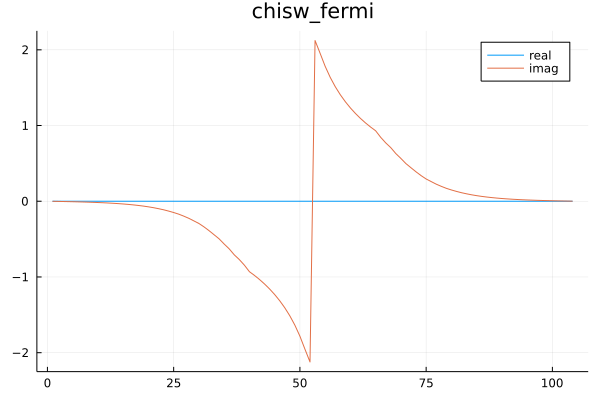

In [19]:
plot(title="chisw_fermi")
plot!(real.(chisw[:]), label="real")
plot!(imag.(chisw[:]), label="imag")

In [20]:
setprecision(512)

512

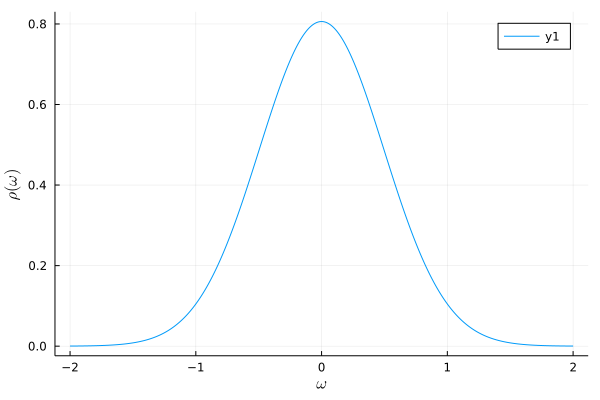

In [85]:
gaussian(x, mu, sigma) = exp(-((x-mu)/sigma)^2)/(sqrt(π)*sigma)
weight = 1.0
rho(omega) = weight*gaussian(omega, 0.0, 0.7)  
#+ 0.5*gaussian(omega, 0.0, 0.1) 
#rho(omega) = weight*gaussian(omega, 0.0, 0.1)  
omegas = LinRange(-2, 2, 1000)
plot(omegas, rho.(omegas), xlabel=latexstring("\\omega"), ylabel=latexstring("\\rho(\\omega)"))

In [86]:
#sum_rule = real(dot(basis.basis_f.u(SparseIR.β(basis)), chisl) + dot(basis.basis_f.u(0), chisl))
sum_rule = real(dot(basis.basis_f.u(SparseIR.β(basis)), chisl) + dot(basis.basis_f.u(0), chisl)) + weight

1.956026385346689

In [87]:
rhol = [overlap(basis.basis_f.v[l], rho) for l in 1:length(basis.basis_f)]
gl = - basis.basis_f.s .* rhol
gw = evaluate(basis.smpl_wn_f, gl)
;

In [89]:
input_chi  = Array{Complex{T}}(undef, hnw) 
input_smpl = Array{Complex{T}}(undef, hnw) 
;

In [90]:
for i in 1:hnw
    input_smpl[i] = SparseIR.valueim(basis.smpl_wn_f.sampling_points[hnw+i], SparseIR.β(basis))
    #input_chi[i]  = -chisw[hnw+i]
    input_chi[i]  = -chisw[hnw+i] + gw[hnw+i]
end

In [91]:
N_real    =  6000
omega_max =  2.0
N_eta     =  10
eta_max   =  0.1
eta_min   =  0.01
H_max     =  50
ab_coeff  = zeros(ComplexF64, 2*H_max) 
lambda    = 1e-5
#1000 → 2000
iter_tol  = 1000
N_imag    =  Nevanlinna.calc_opt_N_imag(hnw, input_smpl, input_chi)
#N_imag    = hnw 
println("N_imag $(N_imag)")

N_imag is setted as 22
N_imag 22


In [92]:
imaginary = Nevanlinna.ImagDomainData(input_smpl, input_chi, N_imag)
raw_reals = Nevanlinna.RealDomainData(N_real, omega_max, eta_min, sum_rule, T=T)
println(typeof(imaginary))
println(typeof(raw_reals))

phis = Nevanlinna.calc_phis(imaginary)
abcd = Nevanlinna.calc_abcd(imaginary, raw_reals, phis)
hardy_matrix = Nevanlinna.calc_hardy_matrix(raw_reals, H_max)

Nevanlinna.evaluation!(raw_reals, abcd, H_max, ab_coeff, hardy_matrix)

Pick matrix is positive semi-definite.
ImagDomainData{BigFloat}
RealDomainData{BigFloat}
max_theta=0.0
hardy optimization was success.


true

In [26]:
function exact_suscep(qx, qy, omega, nsize, beta, hami)
    chi = zeros(ComplexF64, length(omega))
    for iomega in 1:length(omega)
        for ix in 1:nsize, iy in 1:nsize
            kx::Float64 = 2*π*(ix-1)/nsize
            ky::Float64 = 2*π*(iy-1)/nsize
            ek  = hami(kx,ky)
            ekq = hami(kx-qx,ky-qy)
            chi[iomega] += -(IRFLEX.fermi_dirac(ekq,beta)-IRFLEX.fermi_dirac(ek,beta))/(omega[iomega]+ekq-ek)
        end
        chi[iomega] = chi[iomega]/(nsize*nsize)
    end
    return chi
end

exact_suscep (generic function with 1 method)

In [38]:
exa_freq = Array{Complex{T}}(collect(LinRange(-omega_max, omega_max, 1000))) .+ eta_min * im
exa_chi = exact_suscep(π,π,ComplexF64.(exa_freq),nsize,SparseIR.β(basis),hami)
;

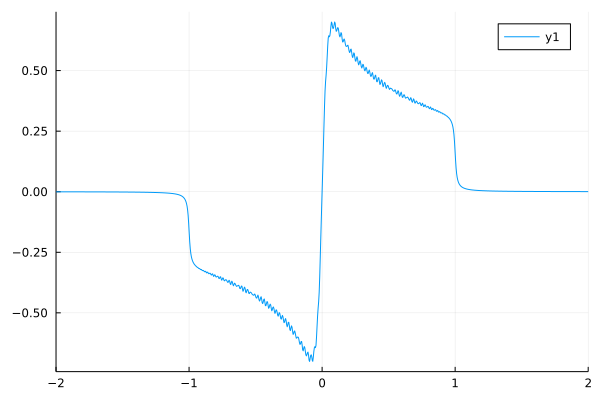

In [39]:
plot(xlim = [-2,2])
plot!(real.(exa_freq), imag.(exa_chi)/pi)

In [40]:
exa_chis = exa_chi ./ (1.0 .- lat.U*exa_chi)
;

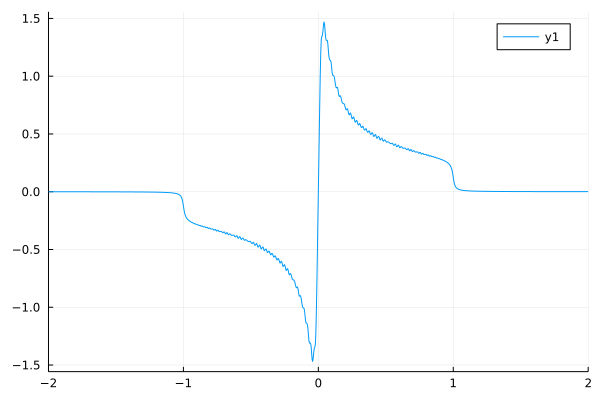

In [41]:
plot(xlim = [-2,2])
plot!(real.(exa_freq), imag.(exa_chis)/pi)

In [95]:
@time sol = Nevanlinna.NevanlinnaSolver(N_imag, input_smpl, input_chi, N_real, omega_max, eta_max, sum_rule, H_max, iter_tol, lambda, true)
;

Pick matrix is positive semi-definite.
H=1
Iter     Function value   Gradient norm 
     0     6.014857e-03     3.731487e-03
 * time: 0.0001900196075439453
     1     5.186087e-03     1.523151e-03
 * time: 3.1336588859558105
     2     5.177253e-03     1.721616e-03
 * time: 5.606159925460815
     3     4.911084e-03     1.939813e-04
 * time: 8.716540813446045
     4     4.908893e-03     3.092588e-06
 * time: 9.869329929351807
     5     4.908892e-03     7.826257e-08
 * time: 11.061415910720825
     6     4.908892e-03     1.566091e-09
 * time: 12.859899044036865
max_theta=0.24571303038698248093669279186237043202970396567266133096526920123311942974138110290275372086977373231301541819670843453729685660825427594518395616679930277
hardy optimization was success.
 16.720184 seconds (224.51 M allocations: 14.198 GiB, 30.17% gc time)


In [96]:
@time Nevanlinna.solve!(sol)
;

H=1
Iter     Function value   Gradient norm 
     0     4.908892e-03     1.566091e-09
 * time: 0.00019407272338867188
max_theta=0.24571303038698248093669279186237043202970396567266133096526920123311942974138110290275372086977373231301541819670843453729685660825427594518395616679930277
hardy optimization was success.
H=2
Iter     Function value   Gradient norm 
     0     4.908892e-03     5.305480e-04
 * time: 0.00019693374633789062
     1     4.763483e-03     3.887537e-04
 * time: 4.101066827774048
     2     4.753941e-03     2.786484e-04
 * time: 7.4946448802948
     3     4.749129e-03     3.940607e-05
 * time: 9.526057004928589
     4     4.749124e-03     3.641508e-05
 * time: 11.561810970306396
     5     4.747580e-03     1.552644e-04
 * time: 15.644073963165283
     6     4.747376e-03     1.614857e-04
 * time: 17.677891969680786
     7     4.744505e-03     1.822342e-04
 * time: 21.763178825378418
     8     4.739927e-03     4.214807e-06
 * time: 23.793324947357178
     9     4.7399

In [102]:
eta_arr = eta_max .- collect(1:N_eta)*((eta_max-eta_min)/(N_eta))
eta_arr[N_eta] = eta_min
;

In [103]:
for ieta = 1:N_eta
    eta_curr  = eta_arr[ieta]
    sol.reals = Nevanlinna.RealDomainData(sol.reals.N_real, sol.reals.omega_max, eta_curr, sol.reals.sum, T=T)
    sol.abcd  = Nevanlinna.calc_abcd(sol.imags, sol.reals, sol.phis)
    sol.H_min = sol.H
    sol.hardy_matrix .= Nevanlinna.calc_hardy_matrix(sol.reals, sol.H_min)
    println("current eta is $(eta_curr)")
    @time Nevanlinna.solve!(sol)
    if isdefined(Main, :IJulia)
        Main.IJulia.stdio_bytes[] = 0
    end
end

current eta is 0.091
H=3
Iter     Function value   Gradient norm 
     0     3.993601e-03     1.352814e-04
 * time: 0.00019598007202148438
     1     3.992558e-03     5.425230e-05
 * time: 3.841062068939209
     2     3.992136e-03     4.265586e-05
 * time: 8.463361024856567
     3     3.992027e-03     2.822829e-05
 * time: 10.68022894859314
     4     3.991993e-03     6.926479e-06
 * time: 14.50659704208374
     5     3.991993e-03     8.319604e-06
 * time: 16.792104959487915
     6     3.991977e-03     6.926798e-06
 * time: 21.36083197593689
     7     3.991976e-03     7.171865e-06
 * time: 23.687148094177246
     8     3.991867e-03     2.712932e-06
 * time: 28.23812699317932
     9     3.991867e-03     2.478398e-06
 * time: 30.47105312347412
    10     3.991864e-03     4.512438e-06
 * time: 35.01483392715454
    11     3.991326e-03     2.063900e-05
 * time: 39.55813407897949
    12     3.991267e-03     3.578829e-07
 * time: 41.864847898483276
    13     3.991267e-03     7.656235e-09
 

    11     2.774586e-03     1.623289e-05
 * time: 38.17101311683655
    12     2.774576e-03     3.720228e-06
 * time: 39.856285095214844
    13     2.774576e-03     3.303649e-06
 * time: 42.35198712348938
    14     2.774571e-03     1.068422e-05
 * time: 47.34816288948059
    15     2.771159e-03     1.084168e-04
 * time: 53.11567306518555
    16     2.766030e-03     7.383897e-06
 * time: 55.55978012084961
    17     2.765980e-03     8.717337e-07
 * time: 57.247812032699585
    18     2.765979e-03     1.740361e-07
 * time: 59.70359706878662
    19     2.765979e-03     6.047903e-08
 * time: 61.39720702171326
    20     2.765979e-03     6.868325e-09
 * time: 62.98249101638794
max_theta=0.959349807918629279198936468415677260516501559727031068816840004155531999622516046726615283172020574695588776128411430709979657201659658430414033328064638799
hardy optimization was success.
H=5
Iter     Function value   Gradient norm 
     0     2.765979e-03     5.828103e-05
 * time: 0.00020313262939453125

    31     2.275684e-03     1.311166e-06
 * time: 107.92046403884888
    32     2.275665e-03     5.040197e-06
 * time: 109.760507106781
    33     2.275661e-03     1.807973e-06
 * time: 111.59264421463013
    34     2.275660e-03     4.163252e-07
 * time: 113.45062518119812
    35     2.275659e-03     4.095293e-07
 * time: 116.31644821166992
    36     2.275659e-03     1.433771e-07
 * time: 118.16312623023987
    37     2.275659e-03     3.362135e-08
 * time: 119.97675108909607
    38     2.275659e-03     1.536994e-08
 * time: 121.78605318069458
    39     2.275659e-03     7.371104e-09
 * time: 124.66050100326538
max_theta=0.997878519528719955498334270936239618952983013243254295332934135212347537521786497481448645553030714760445852862854359950329810367997776268845554390552840114
hardy optimization was success.
H=6
Iter     Function value   Gradient norm 
     0     2.275659e-03     3.866057e-05
 * time: 0.00021600723266601562
     1     2.275637e-03     3.701066e-05
 * time: 5.8190639019

   107     2.046452e-03     4.231001e-05
 * time: 351.7951748371124
   108     2.046425e-03     2.278354e-05
 * time: 353.706778049469
   109     2.046415e-03     2.250220e-05
 * time: 355.63399291038513
   110     2.046405e-03     2.153167e-05
 * time: 357.55309104919434
   111     2.046321e-03     8.327427e-05
 * time: 360.5594639778137
   112     2.046271e-03     7.513136e-05
 * time: 365.37780690193176
   113     2.046241e-03     2.674026e-05
 * time: 367.3053529262543
   114     2.046230e-03     1.736339e-05
 * time: 369.3032429218292
   115     2.046227e-03     2.427113e-05
 * time: 372.2233819961548
   116     2.046226e-03     2.492977e-05
 * time: 374.1401689052582
   117     2.046224e-03     1.892740e-05
 * time: 376.0899169445038
   118     2.046223e-03     1.186012e-05
 * time: 377.98803186416626
   119     2.046222e-03     1.522984e-05
 * time: 379.98261284828186
   120     2.046221e-03     7.173146e-06
 * time: 381.911260843277
   121     2.046221e-03     1.330897e-05
 * t

   228     2.046210e-03     9.699925e-08
 * time: 607.9272518157959
   229     2.046210e-03     5.088427e-08
 * time: 609.8919508457184
   230     2.046210e-03     7.930796e-08
 * time: 611.7933130264282
   231     2.046210e-03     3.486434e-08
 * time: 613.7911849021912
   232     2.046210e-03     6.152643e-08
 * time: 615.7441730499268
   233     2.046210e-03     3.390815e-08
 * time: 617.6431088447571
   234     2.046210e-03     5.625344e-08
 * time: 619.6433818340302
   235     2.046210e-03     3.585611e-08
 * time: 621.5780839920044
   236     2.046210e-03     5.551537e-08
 * time: 623.590301990509
   237     2.046210e-03     3.161144e-08
 * time: 625.5161828994751
   238     2.046210e-03     5.228680e-08
 * time: 627.4340798854828
   239     2.046210e-03     2.945426e-08
 * time: 629.3361649513245
   240     2.046210e-03     4.808930e-08
 * time: 631.3331229686737
   241     2.046210e-03     2.538148e-08
 * time: 633.2556068897247
   242     2.046210e-03     4.387567e-08
 * time:

    51     1.913223e-03     1.348337e-06
 * time: 157.27692198753357
    52     1.913220e-03     1.656748e-06
 * time: 159.28383111953735
    53     1.913214e-03     1.868324e-06
 * time: 162.30121898651123
    54     1.913208e-03     1.903611e-06
 * time: 164.3268439769745
    55     1.913195e-03     2.635011e-06
 * time: 167.43825793266296
    56     1.913183e-03     2.711303e-06
 * time: 169.4489450454712
    57     1.913149e-03     3.899149e-06
 * time: 172.35975909233093
    58     1.913125e-03     3.995337e-06
 * time: 174.38060307502747
    59     1.912992e-03     6.229646e-06
 * time: 178.54325008392334
    60     1.912947e-03     6.563373e-06
 * time: 180.5566110610962
    61     1.912737e-03     7.503379e-06
 * time: 185.4222481250763
    62     1.912032e-03     9.719462e-06
 * time: 187.5483751296997
    63     1.911314e-03     1.382032e-05
 * time: 189.5779790878296
    64     1.909044e-03     2.991127e-05
 * time: 193.52497100830078
    65     1.906400e-03     2.180317e-05

    44     1.702649e-03     2.453012e-06
 * time: 131.78370308876038
    45     1.702648e-03     2.597561e-06
 * time: 133.77721309661865
    46     1.702641e-03     2.377518e-06
 * time: 136.75967597961426
    47     1.702637e-03     2.857643e-06
 * time: 138.7740249633789
    48     1.702616e-03     6.215031e-06
 * time: 141.88184094429016
    49     1.702605e-03     5.628737e-06
 * time: 143.9555640220642
    50     1.702543e-03     1.631527e-05
 * time: 147.05117106437683
    51     1.702506e-03     1.488884e-05
 * time: 149.10344290733337
    52     1.702337e-03     2.699332e-05
 * time: 152.093092918396
    53     1.702239e-03     2.517944e-05
 * time: 154.15156602859497
    54     1.701637e-03     4.849523e-05
 * time: 157.20007300376892
    55     1.701499e-03     4.435932e-05
 * time: 159.3123619556427
    56     1.700289e-03     4.634506e-05
 * time: 162.3704400062561
    57     1.699104e-03     1.318490e-04
 * time: 165.3699450492859
    58     1.682163e-03     2.356673e-04


    40     1.726530e-03     3.716024e-06
 * time: 111.51992702484131
    41     1.726529e-03     4.257086e-06
 * time: 113.50923609733582
    42     1.726526e-03     3.757045e-06
 * time: 116.37243390083313
    43     1.726523e-03     4.199164e-06
 * time: 118.34208989143372
    44     1.726517e-03     3.857302e-06
 * time: 121.21133089065552
    45     1.726511e-03     4.747849e-06
 * time: 123.20903992652893
    46     1.726498e-03     4.675489e-06
 * time: 126.06851387023926
    47     1.726486e-03     5.076270e-06
 * time: 128.06274008750916
    48     1.726452e-03     6.763750e-06
 * time: 130.994558095932
    49     1.726428e-03     6.412553e-06
 * time: 132.98199605941772
    50     1.726311e-03     1.085997e-05
 * time: 136.86557698249817
    51     1.726259e-03     1.051456e-05
 * time: 138.8608729839325
    52     1.725673e-03     1.571204e-05
 * time: 142.7694709300995
    53     1.725326e-03     1.831217e-05
 * time: 144.7628800868988
    54     1.725055e-03     2.773583e-0

    30     2.243320e-03     6.738345e-06
 * time: 90.08604407310486
    31     2.243312e-03     5.717744e-06
 * time: 93.14024996757507
    32     2.243303e-03     6.509908e-06
 * time: 95.08860993385315
    33     2.243278e-03     8.290531e-06
 * time: 98.13117504119873
    34     2.243251e-03     8.801229e-06
 * time: 100.10479497909546
    35     2.243169e-03     1.635545e-05
 * time: 103.01954793930054
    36     2.243086e-03     1.621645e-05
 * time: 105.13242602348328
    37     2.242802e-03     2.590013e-05
 * time: 107.99927186965942
    38     2.242535e-03     2.917120e-05
 * time: 110.13209104537964
    39     2.241385e-03     6.217460e-05
 * time: 113.01685404777527
    40     2.240879e-03     6.019853e-05
 * time: 115.13887000083923
    41     2.239316e-03     5.564208e-05
 * time: 122.26498103141785
    42     2.236902e-03     8.040562e-05
 * time: 125.14877605438232
    43     2.233230e-03     7.062040e-05
 * time: 129.2581889629364
    44     2.232683e-03     7.239014e-0

    49     4.137361e-03     1.159713e-08
 * time: 138.10134196281433
    50     4.137361e-03     1.123163e-08
 * time: 140.0800859928131
    51     4.137361e-03     3.535031e-09
 * time: 142.06426095962524
max_theta=0.868872145092490896726302648975823855173453804748168513650533389036837459774025202574170876513412769264589291018791270533917944562509265698563955591453339575
hardy optimization was success.
H=7
Iter     Function value   Gradient norm 
     0     4.137361e-03     9.677971e-04
 * time: 0.00022292137145996094
     1     4.137326e-03     1.215493e-03
 * time: 2.200684070587158
     2     4.137283e-03     9.281218e-04
 * time: 4.371408939361572
     3     4.137252e-03     9.511416e-04
 * time: 6.393841981887817
     4     4.137172e-03     6.691789e-04
 * time: 8.563461065292358
     5     4.137132e-03     8.956658e-04
 * time: 10.739146947860718
     6     4.136969e-03     3.153347e-04
 * time: 12.769257068634033
     7     4.136933e-03     3.606385e-04
 * time: 14.941725969314

   113     3.942057e-03     3.586188e-04
 * time: 314.4192831516266
   114     3.922700e-03     1.701195e-04
 * time: 317.57355403900146
   115     3.905486e-03     1.421477e-04
 * time: 319.6260139942169
   116     3.904049e-03     1.389877e-04
 * time: 321.81494402885437
   117     3.900935e-03     9.940291e-05
 * time: 323.8742730617523
   118     3.899955e-03     4.878780e-05
 * time: 327.0130031108856
   119     3.899708e-03     2.882764e-05
 * time: 329.0747470855713
   120     3.899665e-03     1.618066e-05
 * time: 332.217787027359
   121     3.899659e-03     4.722214e-06
 * time: 335.3686800003052
   122     3.899659e-03     2.624235e-06
 * time: 337.5436489582062
   123     3.899659e-03     9.681461e-07
 * time: 339.6112971305847
   124     3.899659e-03     4.021798e-07
 * time: 341.71110010147095
   125     3.899659e-03     2.041488e-07
 * time: 344.8945879936218
   126     3.899659e-03     8.390753e-08
 * time: 347.04404401779175
   127     3.899659e-03     3.561026e-08
 * t

    50     9.951974e-03     8.109592e-04
 * time: 144.80552697181702
    51     9.951326e-03     4.424927e-04
 * time: 147.03777194023132
    52     9.950930e-03     1.567702e-04
 * time: 149.23113298416138
    53     9.950743e-03     2.059461e-04
 * time: 151.4277560710907
    54     9.950530e-03     1.318708e-04
 * time: 154.68014001846313
    55     9.950467e-03     1.125774e-04
 * time: 156.85649991035461
    56     9.950450e-03     8.247188e-05
 * time: 160.23122191429138
    57     9.950444e-03     8.649146e-05
 * time: 162.43814897537231
    58     9.950436e-03     2.247297e-05
 * time: 165.6401069164276
    59     9.950432e-03     2.351889e-05
 * time: 167.79789996147156
    60     9.950427e-03     3.231663e-05
 * time: 171.08094811439514
    61     9.950423e-03     3.423091e-05
 * time: 173.29807496070862
    62     9.950417e-03     2.024808e-05
 * time: 176.66466212272644
    63     9.950412e-03     2.011261e-05
 * time: 178.8844919204712
    64     9.950406e-03     2.132947e

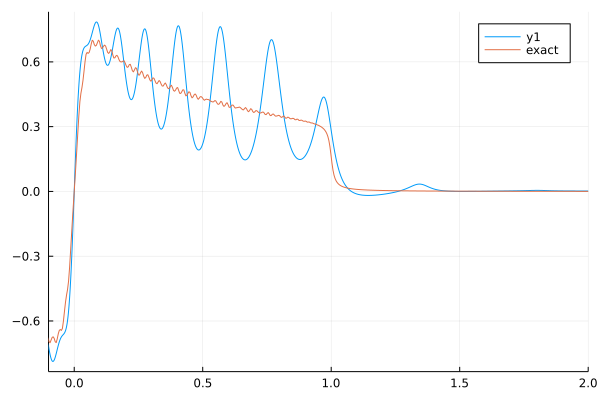

In [94]:
plot(xlim = [-0.1,2])
#plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi).*tanh.(0.5*SparseIR.β(basis)*real.(raw_reals.freq)))
plot!(real.(raw_reals.freq), (imag.(raw_reals.val/pi)- rho.(real.(raw_reals.freq))).*tanh.(0.5*SparseIR.β(basis)*real.(raw_reals.freq)))
plot!(real.(exa_freq), imag.(exa_chi)/pi,label="exact")

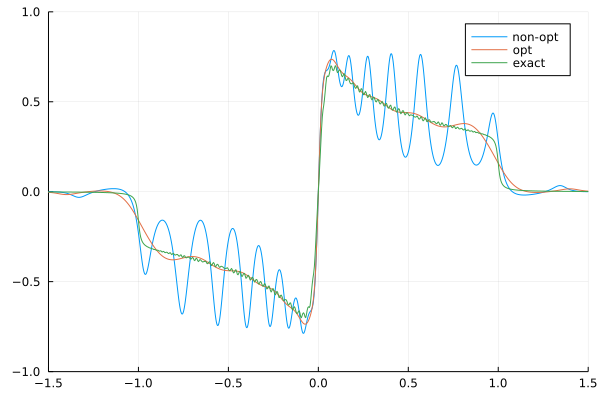

In [106]:
plot(xlim = [-1.5,1.5],ylim= [-1.0,1.0])
#plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi).*tanh.(0.5*SparseIR.β(basis)*real.(raw_reals.freq)),label="non-opt")
plot!(real.(raw_reals.freq), (imag.(raw_reals.val/pi)-rho.(real.(raw_reals.freq))).*tanh.(0.5*SparseIR.β(basis)*real.(raw_reals.freq)),label="non-opt")
#plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val/pi)).*tanh.(0.5*SparseIR.β(basis)*real.(sol.reals.freq)),label="opt")
plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val/pi)-rho.(real.(sol.reals.freq))).*tanh.(0.5*SparseIR.β(basis)*real.(sol.reals.freq)),label="opt")
plot!(real.(exa_freq), imag.(exa_chi)/pi,label="exact")

In [107]:
plot(xlim = [-2,2])
#plot!(real.(raw_reals.freq), imag.(raw_reals.val/(pi*scale)),marker=:+)
#plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val/(pi*scale))))
plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi),marker=:+)
plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val/pi)))

In [38]:
ComplexF64.(raw_reals.freq[1])

-2.0 + 0.001im